# 用户行为模拟


* ## 模型设置

> 用户建模  
* 用户信息base  
* 行为behaviorbase, 定义每种行为，用户付出的行为量化值（聊天轮数，时长，登陆次数，评论次数等）和获取的奖励
* action




In [2]:
import numpy as np
from scipy.stats import halfgennorm,gennorm

In [3]:
class behaviorBase:
    def __init__():
        return
    def generate_qty(self):
        # to be implemented
        return
    
    def generate_reward(self):
        # to be implemented
        return
    
    #行为量化值 如观看时间，登陆
    def getQty(self): 
        self.behavior_qty=self.generate_qty()
        return self.behavior_qty 

    def getReward(self):
        self.reward=self.generate_reward()
        return self.reward

#观看行为
class view(behaviorBase):
    def __init__(self,*rnd,size,exchange):
        self.size = size #日活数量
        self.rnd = rnd #模拟的指数分布参数
        self.exchange = exchange # 行为qty对应的奖励换算比例
        
    def generate_qty(self):
        r = np.random.exponential(*self.rnd,self.size)
        self.qty = np.array(list(map(int,r))) #转化成int型
        return self.qty 
    
    def generate_reward(self):
        return self.qty *self.exchange

#首启-新用户
class firsttime_start(behaviorBase):
    def __init__(self,size,ratio,exchange):
        self.size = size*ratio #size*新用户比例
        self.exchange = exchange # 行为qty对应的奖励换算比例
        
    def generate_qty(self):
        self.qty = self.size #数量=每日新用户
        return self.qty 
    
    def generate_reward(self):
        return self.qty *self.exchange
    
#首次关注
class firstsub_start(behaviorBase):
    def __init__(self,size,ratio,exchange):
        self.size = size*ratio #size*首次关注的比例
        self.exchange = exchange # 行为qty对应的奖励换算比例
        
    def generate_qty(self):
        self.qty = self.size #数量=每日新用户
        return self.qty 
    
    def generate_reward(self):
        return self.qty *self.exchange
    
    
#评论
class comment(behaviorBase):
    def __init__(self,*rnd,size,exchange):
        self.rnd= rnd
        self.size =  size   
        self.exchange = exchange # 行为qty对应的奖励换算比例
        
    def generate_qty(self):
        r = np.random.exponential(*self.rnd,self.size) #评论呈现出指数分布，最多的是0
        self.qty = np.array(list(map(int,r))) #转化成int型
        return self.qty 
    
    def generate_reward(self):
        return self.qty *self.exchange

In [4]:
class actionBase:
    def __init__(self):
        return
    
    def call_act(self):
        #do actions
        return

In [5]:
class userBase(actionBase):
    def __init__(self,new_ratio):
        self.new_ratio = new_ratio
        
    def call_act():
        pass

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

### 用户设定
- 日活用户 DAU 10万
- 日活跃比例 20%
- 月活用户 MAU= DAU / 20%

In [242]:
DAU = int(1e5)
DAU = 100
ratio = 0.2
MAU = int(DAU //ratio)
##指数分布调整系数
scale_factor = 10
bias = 2
print(DAU, MAU)

100 499


### 用户usage 模拟
- 以下是一个长尾分布的使用场景

<Axes: ylabel='Count'>

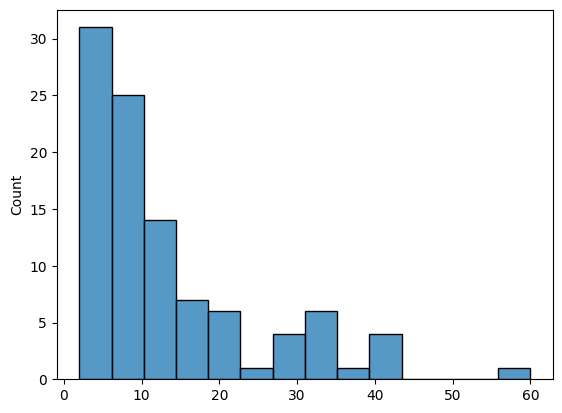

In [243]:
t_rounds = np.round(np.random.exponential((scale_factor),(DAU)))+bias
# sns.distplot(list(map(int,t)))
sns.histplot(t_rounds)

In [244]:
pd.Series(t_rounds).describe()

count    100.000000
mean      13.580000
std       11.465521
min        2.000000
25%        6.000000
50%       10.000000
75%       16.000000
max       60.000000
dtype: float64

- 有些业务可能是其他的情况，比如某个应用的作文修改的场景，最少需要用户聊20轮，一般20～30轮左右

<Axes: ylabel='Count'>

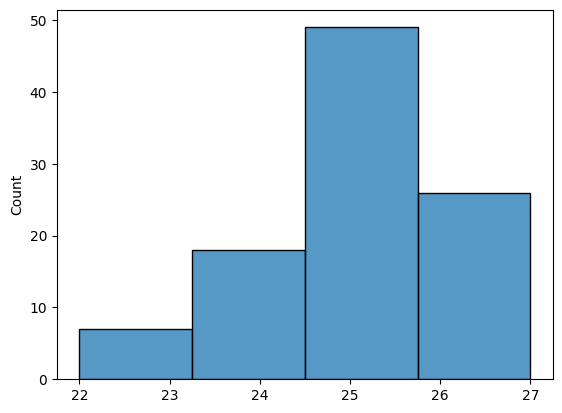

In [301]:
# t_rounds = np.round(np.random.normal(scale_factor),size=(DAU)))+bias
t_rounds = np.round(np.random.normal(loc=25, scale=1, size=(DAU)))
sns.histplot(t_rounds,bins=4)

In [258]:
## 作文修改，反复修改， 20～30轮

In [260]:
pd.Series(t_rounds).describe()

count    100.000000
mean      24.950000
std        1.166667
min       22.000000
25%       24.000000
50%       25.000000
75%       26.000000
max       27.000000
dtype: float64

### 价格计算函数

In [261]:
def calc_rate(input_tokens,output_tokens,model='sonnet'):
    if model == 'sonnet':
        in_token_rate = 3/1e6
        out_token_rate = 15/1e6
    elif model == 'haiku':
        in_token_rate = 0.25/1e6
        out_token_rate = 1.25/1e6
    elif model == 'opus':
        in_token_rate = 15/1e6
        out_token_rate = 75/1e6
    return in_token_rate*input_tokens+out_token_rate*output_tokens

### token数模拟
- 假设每轮的新消息的input token和output token是以正态分布，pure_avg_input_round，avg_output_round分别是期望
- prompt模板的固定token数 fixed_prompt_template_token

<Axes: ylabel='Count'>

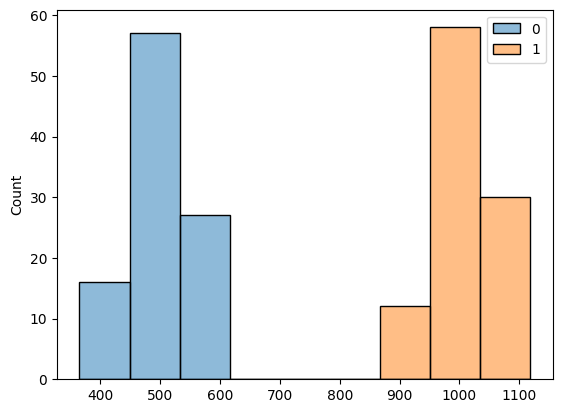

In [262]:
fixed_prompt_template_token= 1500
pure_avg_input_round = 500 ##prompt词 + query 500
avg_output_round = 1000
normal_dist = np.random.normal(loc=(pure_avg_input_round,avg_output_round), scale=pure_avg_input_round/10, size=(DAU,2))
sns.histplot(normal_dist)

In [263]:
pd.DataFrame(normal_dist).describe()

,0,1
count,100.000000,100.000000
mean,498.372598,1002.723938
std,46.742397,47.016847
min,365.391313,883.907208
25%,464.401232,974.829858
50%,499.622931,997.450259
75%,533.288590,1040.891746
max,590.619471,1118.416943


- 计算每轮的输入和输出token产生的费用

In [264]:
pure_avg_cost_round = calc_rate(normal_dist.T[0],normal_dist.T[1],model='sonnet')
pure_avg_cost_round.shape

(100,)

In [265]:
fixed_prompt_template_cost_round = calc_rate(fixed_prompt_template_token,0,model='sonnet')
print(fixed_prompt_template_cost_round)

0.0045000000000000005


- 每轮新对话send给llm的input token = fixed_prompt_template_token + user_input_token, 
- 历史消息的token,不考虑fixed_prompt_template_token. 
- 所以:
- 第n轮的token = (n-1)*(user_input_token+output_token) + (fixed_prompt_template_token + user_input_token+output_token)
- 每轮对话，都会加上前N轮的对话记录，比如聊了n轮的用户，总共需要考虑的消息轮数，应该是1+2+3+...+n
- 所以累加起来就是(user_input_token+output_token) * (1+2+3+..+n-1)+n * (fixed_prompt_template_token + user_input_token+output_token)
- = (user_input_token+output_token)*(1+n) * n/2 + n * fixed_prompt_template_token

- 如果最多保留m轮， 当n>m时， 则实际消耗应该是 ((1+m)*m/2+(n-m) * m) * (user_input_token+output_token)+n * fixed_prompt_template_token
- 所以可以先计算先用户(1+x)* x/2 计算n<=m 之下的部分1，再计算n>m后的超出部分2，用(n-m)* m, 最后加上n* fixed_prompt_template_token 富恩
- 最终三部分之和是总数

In [287]:
max_keep_turns = 10
min_rounds = 1
cliped_t_rounds = np.clip(t_rounds,min_rounds,max_keep_turns)

In [288]:
cliped_t_rounds

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [292]:
part_1=  (1+cliped_t_rounds)*cliped_t_rounds /2 * pure_avg_cost_round

In [293]:
part_2= np.clip((t_rounds-cliped_t_rounds),0,t_rounds.max())*max_keep_turns * pure_avg_cost_round

In [294]:
part_3 = t_rounds*fixed_prompt_template_cost_round

In [295]:
total_rounds_accu_history = part_1 + part_2 + part_3

In [296]:
rounds_cost = total_rounds_accu_history

总rounds:2495,总cost:344


<Axes: ylabel='Count'>

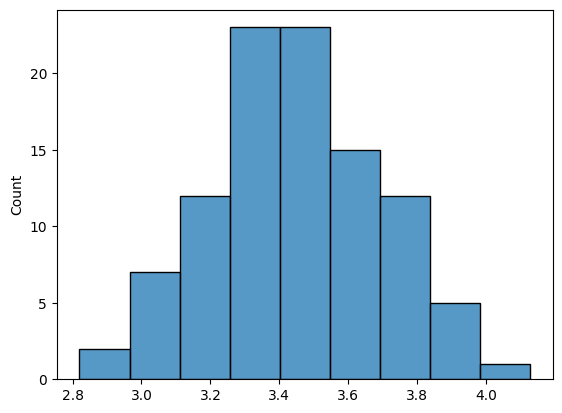

In [297]:
print('总rounds:%d,总cost:%d' %(t_rounds.sum(),rounds_cost.sum()))
sns.histplot(rounds_cost)

In [1]:
rounds_df = pd.Series(t_rounds)
rounds_df.describe()

NameError: name 'pd' is not defined

In [127]:
rounds_cost = pd.Series(rounds_cost)
rounds_cost.describe()

count    100000.000000
mean          3.449304
std           0.236508
min           2.497780
25%           3.286855
50%           3.445496
75%           3.608273
max           4.486777
dtype: float64

### 按用户的轮数占比分层，看各层的cost占比

In [128]:
cost_pct = []
total = rounds_cost.sum()
for q in np.arange(0,1,0.1):
    b = rounds_cost.quantile(q)
    cost_pct.append([q,rounds_cost[rounds_cost>=b].sum()/total])
    

In [129]:
data = pd.DataFrame(cost_pct,columns=['percentile','cost occupation'])

In [130]:
data

,percentile,cost occupation
0,0.0,1.000000
1,0.1,0.911761
2,0.2,0.818937
3,0.3,0.723669
4,0.4,0.626435
5,0.5,0.527419
6,0.6,0.426643
7,0.7,0.324065
8,0.8,0.219440
9,0.9,0.112247


In [353]:
## 定义每月的租金
## 聊的论数越多token越多
## 自建模型的成本，1月的时间周期。

In [271]:
# sns.relplot(data=data,x='x',y='y')

In [131]:
total_cost = rounds_cost.sum()

In [132]:
total_cost*30/MAU

20.695866432069465

In [355]:
from scipy import optimize

In [363]:
c=np.array([2,3,-5])
A_ub=np.array([[-2,5,-1],[1,3,1]])
B_ub=np.array([-10,12])
A_eq=np.array([[1,1,1]])
B_eq=np.array([7])
x1=(0,100)
x2=(0,100)
x3=(0,7)
res=optimize.linprog(-c,A_ub,B_ub,A_eq,B_eq,bounds=(x1,x2,x3))
print(res)

     con: array([0.])
     fun: -14.571428571428571
 message: 'Optimization terminated successfully.'
     nit: 8
   slack: array([0.        , 3.85714286])
  status: 0
 success: True
       x: array([6.42857143, 0.57142857, 0.        ])


In [413]:
x = np.linspace(0,100,100)

In [414]:
y = np.log(3+2*x)
y = np.exp(-10*x)

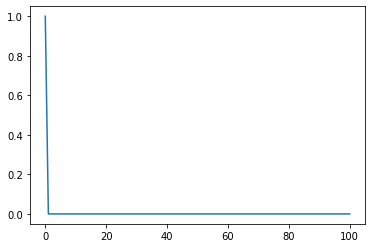

In [415]:
plt.plot(x,y)

In [416]:
np.random.exponential(10,10)

array([ 2.04571528, 32.22290026, 11.01366368, 10.82994786,  2.77600893,
        3.761561  , 22.96969816,  3.34054414,  0.83794107, 25.95941906])